<a href="https://colab.research.google.com/github/felixlyg/Assignment-3/blob/main/Assignment_3_%7C_%CE%BB_%3D_0_25_%7C_Nf_%3D_70k_%7C_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Introduction and Setup

##### Preliminaries (pip, import, cuda, mount)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install numpy matplotlib scipy pyDOE tqdm tensorboardX -q
!pip install torch -q
!pip install torch --upgrade

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.spatial import distance
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import time
from pyDOE import lhs
from tqdm import tqdm
import torch.nn as torch
import torch.optim as optim
import pdb
from IPython.core.debugger import set_trace as ipdb_set_trace
import logging
import torch.nn.init as init
import torch.nn.functional as F
import torch
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Data Pre-processing

##### Preparing the Data (cropping, etc.)

The data was cropped to focus on the wake region behind the cylinder, where significant fluid dynamics occur, while also reducing computational complexity and enhancing numerical stability. The reshaped and processed data is then ready for input into machine learning models for further analysis, ensuring that each data point is accurately associated with its spatial and temporal coordinates. This approach aligns with the need for efficient data handling in high-resolution CFD simulations and machine learning applications.

In [ ]:
def load_and_reshape_data(data_path):
    data = scipy.io.loadmat(data_path)
    steps, n, m, dt, dx, dy = 151, 449, 199, 0.2, 0.02, 0.02

    W = data['VORTALL'].reshape(n, m, steps)  # vorticity (.size (13492001, 1)
    U = data['UALL'].reshape(n, m, steps)     # x-component of velocity (shape same as W)
    V = data['VALL'].reshape(n, m, steps)     # y-component of velocity (shape same as W)
    # Cut out the portion of the data before the cylinder
    W = W[100:425, 15:185, :]
    U = U[100:425, 15:185, :]
    V = V[100:425, 15:185, :]
    n, m, steps = W.shape

    # Reshape data for neural network input
    w_data, u_data, v_data = W.reshape(n * m, steps), U.reshape(n * m, steps), V.reshape(n * m, steps)
    t_data = np.tile(np.arange(steps).reshape((1, -1)) * dt, (m * n, 1))
    x_data = np.tile(np.arange(n).reshape((-1, 1)) * dx, (1, m)).reshape(-1, 1)
    x_data = np.tile(x_data, (1, steps))
    y_data = np.tile(np.arange(m).reshape((1, -1)) * dy, (n, 1)).reshape(-1, 1)
    y_data = np.tile(y_data, (1, steps))

    # Prepare input data for neural network
    t_star, x_star, y_star = t_data.reshape(-1, 1), x_data.reshape(-1, 1), y_data.reshape(-1, 1)
    u_star, v_star, w_star = u_data.reshape(-1, 1), v_data.reshape(-1, 1), w_data.reshape(-1, 1)
    X_star = np.hstack((x_star, y_star, t_star))
    return X_star, u_star, v_star, w_star, x_data, y_data, t_data, u_data, v_data, w_data, W, U, V, steps, n, m

##### **PiNN and MLP Pre-processing**

This section is code adapted from the original paper (Chen et al. 2020).

In [ ]:
def prepare_pinn_mlp_data(X_star, x_data, y_data, t_data, u_data, v_data, w_data, N_s, N_t, split_ratio, noise, steps):
    """
    This function prepares the data for training and validation of PINN and MLP models.
    It randomly selects spatial and temporal measurement points from the input data.

    The measurement data is reshaped and concatenated to create the input data array (X_meas).
    The corresponding target data arrays (u_meas, v_meas, w_meas) are also reshaped.

    The measurement data is split into training and validation sets based on the `split_ratio`.
    Gaussian noise is added to the training and validation target data arrays.

    The function returns the training and validation data arrays (X_train, u_train, v_train, w_train)
    and (X_val, u_val, v_val, w_val), respectively.
    """
    # Prepare measurement data
    idx_s, idx_t = np.random.choice(x_data.shape[0], N_s, replace=False), np.random.choice(steps, N_t, replace=False)

    # Reshape measurement data
    t_meas = t_data[idx_s, :][:, idx_t].reshape(-1, 1)
    x_meas = x_data[idx_s, :][:, idx_t].reshape(-1, 1)
    y_meas = y_data[idx_s, :][:, idx_t].reshape(-1, 1)
    u_meas = u_data[idx_s, :][:, idx_t].reshape(-1, 1)
    v_meas = v_data[idx_s, :][:, idx_t].reshape(-1, 1)
    w_meas = w_data[idx_s, :][:, idx_t].reshape(-1, 1)
    X_meas = np.hstack((x_meas, y_meas, t_meas))

    # Split measurement data into training and validation sets
    N_train = int(N_s * N_t * split_ratio)
    idx_train = np.random.choice(X_meas.shape[0], N_train, replace=False)
    X_train = X_meas[idx_train, :]
    u_train = u_meas[idx_train, :]
    v_train = v_meas[idx_train, :]
    w_train = w_meas[idx_train, :]
    idx_val = np.setdiff1d(np.arange(X_meas.shape[0]), idx_train, assume_unique=True)
    X_val = X_meas[idx_val, :]
    u_val = u_meas[idx_val, :]
    v_val = v_meas[idx_val, :]
    w_val = w_meas[idx_val, :]

    # Add noise to measurement data
    u_train = u_train + noise * np.std(u_train) * np.random.randn(u_train.shape[0], u_train.shape[1])
    v_train = v_train + noise * np.std(v_train) * np.random.randn(v_train.shape[0], v_train.shape[1])
    w_train = w_train + noise * np.std(w_train) * np.random.randn(w_train.shape[0], w_train.shape[1])
    u_val = u_val + noise * np.std(u_val) * np.random.randn(u_val.shape[0], u_val.shape[1])
    v_val = v_val + noise * np.std(v_val) * np.random.randn(v_val.shape[0], v_val.shape[1])
    w_val = w_val + noise * np.std(w_val) * np.random.randn(w_val.shape[0], w_val.shape[1])

    return X_train, u_train, v_train, w_train, X_val, u_val, v_val, w_val

##### **CNN Data Pre-processing**
  
  This function prepares the data for the hyrbid CNN model.
  We have time-sequenced data where each sequence consists of multiple frames representing different time steps.
  Each frame in the sequence should be processed correctly by adjusting dimensions accordingly before feeding into convolutional layers.

---



In [ ]:
def add_gaussian_noise(data, std):
    noise = np.random.normal(0, std, data.shape)
    return data + noise

def cnn_lstm_data(U, V, W, seq_len, split_ratio, train_batch_size, val_batch_size, noise):
    """
    This function prepares the data for training and validation of a CNN-LSTM model.
    It normalizes the input data components (U, V, W) and adds Gaussian noise to them.
    The noisy data components are then stacked along a new axis to create a single data array.

    The input sequences are created by sliding a window of length `seq_len` over the data array,
    and the corresponding target sequences are the next time step after each input sequence.

    The data is split into training and validation sets based on the `split_ratio`.
    The input and target sequences are converted to PyTorch tensors.

    Finally, the function creates PyTorch datasets and dataloaders for training and validation,
    with the specified batch sizes and shuffling options.
    """
    normalized_U = (U - U.mean()) / U.std()
    normalized_V = (V - V.mean()) / V.std()
    normalized_W = (W - W.mean()) / W.std()

    # Add Gaussian noise to the normalized data
    noisy_U = add_gaussian_noise(normalized_U, std=noise)
    noisy_V = add_gaussian_noise(normalized_V, std=noise)
    noisy_W = add_gaussian_noise(normalized_W, std=noise)

    # Stack the noisy components along a new axis
    normalized_data = np.stack([noisy_U, noisy_V, noisy_W], axis=-1)

    # Stack the normalized components along a new axis
    # normalized_data = np.stack([normalized_U, normalized_V, normalized_W], axis=-1)

    # Preallocate arrays for input and target sequences
    num_sequences = normalized_data.shape[2] - seq_len
    input_seq = np.zeros((num_sequences, normalized_data.shape[0], normalized_data.shape[1], seq_len, 3))
    target_seq = np.zeros((num_sequences, normalized_data.shape[0], normalized_data.shape[1], 3))

    for t in range(num_sequences):
        input_seq[t] = normalized_data[:, :, t:t+seq_len, :]
        target_seq[t] = normalized_data[:, :, t+seq_len, :]

    # Split the data into training and validation sets
    split_index = int(num_sequences * split_ratio)
    train_input = input_seq[:split_index]
    val_input = input_seq[split_index:]
    train_target = target_seq[:split_index]
    val_target = target_seq[split_index:]

    # Convert to PyTorch tensors
    train_input = torch.tensor(train_input, dtype=torch.float32)
    val_input = torch.tensor(val_input, dtype=torch.float32)
    train_target = torch.tensor(train_target, dtype=torch.float32)
    val_target = torch.tensor(val_target, dtype=torch.float32)

    train_dataset = TensorDataset(train_input, train_target)
    val_dataset = TensorDataset(val_input, val_target)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=0, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False, num_workers=0, pin_memory=True)

    return train_loader, val_loader


#### **Architecture definitions (3)**

Three architectures are explored.

  1. Firstly, a straightforward MLP with fully connected layers and Tanh activations to model the vorticity field. It uses mean squared error (MSE) for data loss.

  2. Second, we combine Conv blocks for spatial feature extraction with LSTM for temporal features. Uses residual blocks and MSE for data loss.

  3. For our PINN there are physics constraints using Fourier features to enhance learning of fluid dynamics. Combines data and physics-based loss.

---




In [ ]:
class MLP(nn.Module):

    def __init__(self, layers, device):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()

        for i in range(0, len(layers)-1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers) - 2:
                self.layers.append(nn.Tanh())
        self.to(device)
        # Apply Glorot initialization to the weights
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    init.zeros_(layer.bias)
        self.to(device)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    # Naive Neural Network which is a vanilla MLP (simple feedforward Neural Net)
    def compute_loss(self, x, u, v, w, X_f, lam):
        # Enabling gradient computation
        x.requires_grad_(True)
        u_pred, v_pred, w_pred = self.forward(x).split(1, dim=1)
        data_loss = nn.MSELoss()(u_pred, u) + nn.MSELoss()(v_pred, v) + nn.MSELoss()(w_pred, w)

        return data_loss

In [ ]:
class FourierFeatures(nn.Module):
    def __init__(self, in_features, out_features, scale):
        super(FourierFeatures, self).__init__()
        self.B = nn.Parameter(scale * torch.randn(in_features, out_features), requires_grad=False)

    def forward(self, x):
        x_proj = x @ self.B
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class PINN(nn.Module):
    def __init__(self, layers, device, embed_dim, scale):#, mu, sigma):
        super(PINN, self).__init__()
        self.embed_dim = embed_dim
        self.fourier_features = FourierFeatures(layers[0], embed_dim, scale)
        self.layers = nn.ModuleList()
        in_features = embed_dim * 2  # Because we concatenate sin and cos outputs

        for i in range(1, len(layers)):
            self.layers.append(nn.Linear(in_features, layers[i]))
            if i < len(layers) - 1:
                self.layers.append(nn.Tanh())
            in_features = layers[i]

        # Apply Glorot initialization to the weights
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    init.zeros_(layer.bias)

        self.to(device)

    def forward(self, x):
        x = self.fourier_features(x)
        for layer in self.layers:
            x = layer(x)
        return x

    def compute_loss(self, x, u, v, w, X_f, lam):
        x.requires_grad_(True)
        output = self.forward(x)
        u_pred, v_pred, w_pred = output.split(1, dim=1)
        data_loss = nn.MSELoss()(u_pred, u) + nn.MSELoss()(v_pred, v) + nn.MSELoss()(w_pred, w)
        X_f.requires_grad_(True) # Enabling gradient computation for physics loss
        output_f = self.forward(X_f)
        u_f, v_f, w_f = output_f.split(1, dim=1)

        # Calculating gradients
        w_f_sum = w_f.sum()
        w_f_t = torch.autograd.grad(w_f_sum, X_f, create_graph=True)[0][:, 2:3]  # ∂ω/∂t
        w_f_x = torch.autograd.grad(w_f_sum, X_f, create_graph=True)[0][:, 0:1]  # ∂ω/∂x
        w_f_y = torch.autograd.grad(w_f_sum, X_f, create_graph=True)[0][:, 1:2]  # ∂ω/∂y
        w_f_x_sum = w_f_x.sum()
        w_f_y_sum = w_f_y.sum()
        w_f_xx = torch.autograd.grad(w_f_x_sum, X_f, create_graph=True)[0][:, 0:1]  # ∂²ω/∂x²
        w_f_yy = torch.autograd.grad(w_f_y_sum, X_f, create_graph=True)[0][:, 1:2]  # ∂²ω/∂y²

        # Velocity divergence-free condition (incompressibility)
        u_f_sum = u_f.sum()
        v_f_sum = v_f.sum()
        u_f_x = torch.autograd.grad(u_f_sum, X_f, create_graph=True)[0][:, 0:1]  # ∂u/∂x
        v_f_y = torch.autograd.grad(v_f_sum, X_f, create_graph=True)[0][:, 1:2]  # ∂v/∂y
        # Divergence-free condition
        divergence_loss = nn.MSELoss()(u_f_x + v_f_y, torch.zeros_like(u_f_x))
        # Physics-based loss calculation
        physics_loss = nn.MSELoss()( w_f_t + u_f * w_f_x + v_f * w_f_y - (0.01) * (w_f_xx + w_f_yy), torch.zeros_like(w_f))
        return data_loss + lam * (physics_loss + divergence_loss) # Total loss

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock3D, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm3d(out_channels))

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class CNNLSTM(nn.Module):
    def __init__(self, hidden_dim, num_layers):
        super(CNNLSTM, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv3d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2, padding=1),
            ResidualBlock3D(64, 128, stride=2),
            ResidualBlock3D(128, 256, stride=2),
            ResidualBlock3D(256, 256, stride=2),
            nn.AdaptiveAvgPool3d((1, 1, 1)))

        self.flatten = nn.Flatten()
        self.lstm = nn.LSTM(input_size=256, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 3 * 325 * 170))

        # Weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv3d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        batch_size, seq_len, channels, height, width = x.size()
        x = x.reshape(batch_size * seq_len, channels, height, width)  # Combine batch and seq_len dimensions for 3D CNN
        x = x.unsqueeze(2)
                                                                     # Shape: (batch_size * seq_len, channels, 1, height, width)
        encoded = self.encoder(x)                                     # Encode with 3D CNN
        encoded = encoded.view(batch_size, seq_len, -1)               # Reshape for LSTM
        lstm_out, _ = self.lstm(encoded)                              # Shape: (batch_size, seq_len, feature_dim)
        lstm_out = lstm_out[:, -1, :]
        decoded = self.decoder(lstm_out.squeeze(1))                   # Take the output of the last time step
        decoded = self.decoder(lstm_out)                              # Decode output
        decoded = decoded.view(batch_size, 3, 325, 170)               # Reshape to match target size
        return decoded

#### Training the model + Main

###### Training Loop

In [ ]:
def train_w_eval(model, X_train, u_train, v_train, w_train, X_val, u_val, v_val, w_val, X_f, epochs, batch_size, lr, lam, device):
    """
    This function trains the specified model using a hybrid optimization approach, integrating AdamW and LBFGS
    optimizers to leverage their respective strengths in convergence speed and accuracy. It is designed to support
    both CNN-LSTM and PINN/MLP models.

    For CNN-LSTM models, the function expects input data formatted as (batch_size, seq_len, height, width, channels).
    The data is permuted and reshaped accordingly to fit the model's requirements. The training loss is computed
    using Mean Squared Error (MSE), a standard metric for regression tasks.

    For PINN and MLP models, the optimizer is chosen dynamically based on the current loss
    value, alternating between AdamW and LBFGS to balance fast convergence with fine-tuning precision.

    Throughout the training process, the function maintains the state of the model that achieves the lowest
    validation loss. It also implements early stopping to cease training if no improvement in validation
    loss is observed over a predetermined number of epochs.

    Upon completion, the function returns the trained model along with the histories of training and validation
    losses, providing a comprehensive overview of the model's performance over the training period.
    """

    optimizer1 = optim.AdamW(model.parameters(), lr=lr) # , weight_decay=1e-4)
    optimizer2 = optim.LBFGS(model.parameters(), lr=lr*5, max_iter=20, max_eval=None, tolerance_grad=1e-07,
                             tolerance_change=1e-09, history_size=100, line_search_fn='strong_wolfe')
    losses, eval_losses = [], []
    patience = 50
    min_delta = 0.001
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in tqdm(range(epochs), desc="Training Progress"):
        model.train()
        temp_loss = 0.0
        val_loss = 0.0
        if isinstance(model, CNNLSTM):
            for idx, (input_batch, target_batch) in enumerate(X_train):
                batch_size, seq_len, height, width, channels = input_batch.shape
                input_batch = input_batch.permute(0, 1, 3, 4, 2).contiguous()
                input_batch = input_batch.view(batch_size, seq_len, channels, height, width)
                input_batch = input_batch.to(device)
                target_batch = target_batch.permute(0, 3, 1, 2).to(device)

                predictions = model(input_batch)
                loss = nn.MSELoss()(predictions, target_batch)

                optimizer1.zero_grad()
                loss.backward()
                optimizer1.step()

                temp_loss += loss.item() * input_batch.size(0)
            temp_loss /= len(X_train.dataset)
            losses.append(temp_loss)

            model.eval()
            with torch.no_grad():
                val_loss = 0.0
                for idx, (input_batch, target_batch) in enumerate(X_val):
                    batch_size, seq_len, height, width, channels = input_batch.shape
                    input_batch = input_batch.permute(0, 1, 3, 4, 2).contiguous()
                    input_batch = input_batch.view(batch_size, seq_len, channels, height, width)
                    input_batch = input_batch.to(device)
                    target_batch = target_batch.permute(0, 3, 1, 2).to(device)

                    predictions = model(input_batch)
                    loss = nn.MSELoss()(predictions, target_batch)

                    val_loss += loss.item() * input_batch.size(0)

                val_loss /= len(X_val.dataset)
                eval_losses.append(val_loss)

        elif isinstance(model, (PINN, MLP)):
            for i in range(0, X_train.shape[0], batch_size):
                x_batch = X_train[i:i + batch_size].to(device)
                u_batch = u_train[i:i + batch_size].to(device)
                v_batch = v_train[i:i + batch_size].to(device)
                w_batch = w_train[i:i + batch_size].to(device)

                def closure():
                    optimizer.zero_grad()
                    loss = model.compute_loss(x_batch, u_batch, v_batch, w_batch, X_f, lam)
                    loss.backward(retain_graph=True)
                    return loss.detach()

                optimizer = optimizer2 if len(losses) == 0 or (losses[-1] > 0.005) else optimizer1

                optimizer.step(closure)
                temp_loss += closure().item() * x_batch.size(0)

            temp_loss /= len(X_train)
            losses.append(temp_loss)

            model.eval()
            idx = np.random.choice(X_val.shape[0], batch_size, replace=False)
            x_batch = X_val[idx].to(device)
            u_batch = u_val[idx].to(device)
            v_batch = v_val[idx].to(device)
            w_batch = w_val[idx].to(device)
            eval_loss = model.compute_loss(x_batch, u_batch, v_batch, w_batch, X_f, lam).item()
            eval_losses.append(eval_loss)

        # Early stopping mechanism
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

        if (epoch + 1) % 10 == 0 and len(losses) > 0 and len(eval_losses) > 0:
            tqdm.write(f"Epoch {epoch + 1}/{epochs}, "
                        f"Loss: {losses[-1]:.4f}, "
                        f"Val Loss: {eval_losses[-1]:.4f}")

    return model, losses, eval_losses

##### Main Block

In [ ]:
if __name__ == "__main__":

    # Load and reshape data
    data_path = '/content/drive/MyDrive/A3/nse.mat'
    X_star, u_star, v_star, w_star, x_data, y_data, t_data, u_data, v_data, w_data, W, U, V, steps, n, m = load_and_reshape_data(data_path)
    # Prepare the data
    split_ratio = 0.8  # 80% training, 20% validation
    # Set training hyperparameters
    # epochs = 128
    epochs = 128
    batch_size = 512
    noise = 0.01  # HYPERPARAMETER
    seq_len = 5 # Length or Depth (sequence of velocity fields)
    train_batch_size, val_batch_size = 8, 8
    train_loader, val_loader = cnn_lstm_data(U, V, W, seq_len, split_ratio, train_batch_size, val_batch_size, noise)

    ## Spatially randomly but temporally continuously sampled measurements
    N_s, N_t = 500, 60  # Number of spatial and temporal points to sample from meshgrid (325, 170, 151)


    # HYPERPARAMETERS
    N_f = 2000 # Number of Collocation points (or where residuals are minimised)
    lr = 0.001
    lam = 1 # λ Weighting coefficient for loss function

    X_train, u_train, v_train, w_train, X_val, u_val, v_val, w_val = prepare_pinn_mlp_data(
        X_star, x_data, y_data, t_data, u_data, v_data, w_data, N_s, N_t, split_ratio, noise, steps)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Tensors for autograd & stacking
    X_train = torch.tensor(X_train, dtype=torch.float32).view(-1, 3).to(device)
    u_train = torch.tensor(u_train, dtype=torch.float32).view(-1, 1).to(device)
    v_train = torch.tensor(v_train, dtype=torch.float32).view(-1, 1).to(device)
    w_train = torch.tensor(w_train, dtype=torch.float32).view(-1, 1).to(device)

    X_val = torch.tensor(X_val, dtype=torch.float32).view(-1, 3).to(device)
    u_val = torch.tensor(u_val, dtype=torch.float32).view(-1, 1).to(device)
    v_val = torch.tensor(v_val, dtype=torch.float32).view(-1, 1).to(device)
    w_val = torch.tensor(w_val, dtype=torch.float32).view(-1, 1).to(device)

    lb = X_star.min(0)[0]  # Lower bound is just 0
    ub = X_star.max(0)[-1]  # Upper bound of x, y, t (take from cropped matrix) t always biggest in field

    X_f = lb + (ub - lb) * torch.tensor(lhs(3, N_f), dtype=torch.float32, requires_grad=True).to(device) # input is 3 dimensions (x, y, t)
    X_f = torch.vstack((X_f, X_train))
    # PINN + MLP Layers
    MLPLayers = [3, 32, 32, 32, 32, 32, 3]
    PiNNLayers = [3, 32, 32, 32, 32, 32, 3]
    embedded_dim = 50
    scale = 2 # Best practice hyperparameter from literature
    # Instantiate the model
    model_PINN = PINN(PiNNLayers, device, embedded_dim, scale)
    model_MLP = MLP(MLPLayers, device)
    hidden_dim = 128  # HYPERPARAM
    num_layers = 8  # HYPERPARAM
    model_CNNLSTM = CNNLSTM(hidden_dim, num_layers).to(device)


    _PINN, Ploss, Peval = train_w_eval(model_PINN, X_train, u_train, v_train, w_train, X_val, u_val, v_val, w_val, X_f, epochs, batch_size, lr, lam, device)
    baseline_MLP, Mloss, Meval = train_w_eval(model_MLP, X_train, u_train, v_train, w_train, X_val, u_val, v_val, w_val, X_f, epochs, batch_size, lr, lam, device)
    batch_size = 32
     # BATCH SIZE FOR CNN AND PiNN (and MLP) ARE DIFFERENT DUE TO NATURE OF ARCHITECTURES
    baseline_CNNLSTM, Closs, Ceval = train_w_eval(model_CNNLSTM, train_loader, None, None, None, val_loader, None, None, None, None, epochs, batch_size, lr, None, device)

   # ~~~~~~~~~~~~~~~~ CHANGE BATCH SIZES | HYPERPARAMETERS ~~~~~~~~~~~~~ #
    # Save the trained models
    torch.save(model_PINN.state_dict(), "model_PINN.pth")
    torch.save(baseline_MLP.state_dict(), "baseline_MLP.pth")
    torch.save(baseline_CNNLSTM.state_dict(), "baseline_CNNLSTM.pth")

Training Progress:   8%|▊         | 10/128 [05:02<59:53, 30.46s/it] 

Epoch 10/128, Loss: 0.1507, Val Loss: 0.1810


Training Progress:  16%|█▌        | 20/128 [10:06<54:34, 30.32s/it]

Epoch 20/128, Loss: 0.1309, Val Loss: 0.1511


Training Progress:  23%|██▎       | 30/128 [15:09<49:31, 30.32s/it]

Epoch 30/128, Loss: 0.1178, Val Loss: 0.1337


Training Progress:  31%|███▏      | 40/128 [20:13<44:48, 30.55s/it]

Epoch 40/128, Loss: 0.1091, Val Loss: 0.1268


Training Progress:  39%|███▉      | 50/128 [25:17<39:22, 30.28s/it]

Epoch 50/128, Loss: 0.1023, Val Loss: 0.1232


Training Progress:  39%|███▉      | 50/128 [25:47<40:13, 30.94s/it]


Early stopping triggered at epoch 51


Training Progress:   8%|▊         | 10/128 [01:22<16:27,  8.37s/it]

Epoch 10/128, Loss: 0.4685, Val Loss: 0.4643


Training Progress:  16%|█▌        | 20/128 [02:47<15:16,  8.49s/it]

Epoch 20/128, Loss: 0.4524, Val Loss: 0.5842


Training Progress:  23%|██▎       | 30/128 [04:12<13:54,  8.51s/it]

Epoch 30/128, Loss: 0.4493, Val Loss: 0.4104


Training Progress:  31%|███▏      | 40/128 [05:37<12:23,  8.45s/it]

Epoch 40/128, Loss: 0.4406, Val Loss: 0.5021


Training Progress:  39%|███▉      | 50/128 [07:01<11:02,  8.49s/it]

Epoch 50/128, Loss: 0.4364, Val Loss: 0.5590


Training Progress:  39%|███▉      | 50/128 [07:10<11:11,  8.61s/it]


Early stopping triggered at epoch 51


Training Progress:   8%|▊         | 10/128 [00:17<03:23,  1.72s/it]

Epoch 10/128, Loss: 0.6208, Val Loss: 0.6187


Training Progress:  16%|█▌        | 20/128 [00:34<03:05,  1.71s/it]

Epoch 20/128, Loss: 0.6221, Val Loss: 0.6197


Training Progress:  23%|██▎       | 30/128 [00:51<02:46,  1.70s/it]

Epoch 30/128, Loss: 0.6191, Val Loss: 0.6125


Training Progress:  31%|███▏      | 40/128 [01:08<02:31,  1.72s/it]

Epoch 40/128, Loss: 0.6220, Val Loss: 0.6214


Training Progress:  39%|███▉      | 50/128 [01:25<02:12,  1.70s/it]

Epoch 50/128, Loss: 0.6217, Val Loss: 0.6197


Training Progress:  47%|████▋     | 60/128 [01:43<01:56,  1.72s/it]

Epoch 60/128, Loss: 0.6189, Val Loss: 0.6190


Training Progress:  55%|█████▍    | 70/128 [02:00<01:39,  1.71s/it]

Epoch 70/128, Loss: 0.6177, Val Loss: 0.6183


Training Progress:  62%|██████▏   | 79/128 [02:17<01:25,  1.74s/it]

Early stopping triggered at epoch 80


#### Results and Analysis

##### Validation and Training Losses

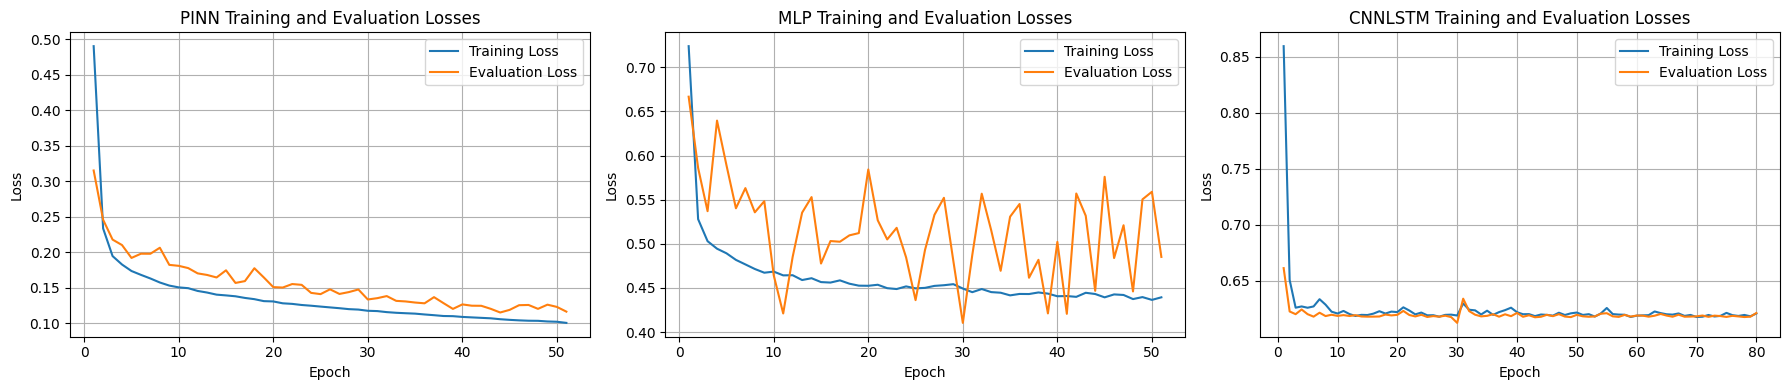

In [ ]:
import matplotlib.pyplot as plt

def plot_losses(ax, train_losses, eval_losses, title, ylim=None, xlim=None):
    ax.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    ax.plot(range(1, len(eval_losses) + 1), eval_losses, label='Evaluation Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(title)
    ax.legend()
    ax.grid(True)

    if ylim is not None:
        ax.set_ylim(ylim)  # Set the y-axis limits for zooming

    if xlim is not None:
        ax.set_xlim(xlim)  # Set the x-axis limits for zooming

# Create a figure with 3 subplots arranged in a row
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Plot training and evaluation losses for PINN (zoomed in)
plot_losses(axes[0], Ploss, Peval, 'PINN Training and Evaluation Losses')#, ylim=(0, 0.8))

# Plot training and evaluation losses for MLP (zoomed in)
plot_losses(axes[1], Mloss, Meval, 'MLP Training and Evaluation Losses')#, ylim=(0, 0.8))

# Plot training and evaluation losses for CNNLSTM (zoomed in)
plot_losses(axes[2], Closs, Ceval, 'CNNLSTM Training and Evaluation Losses')#, ylim=(0, 0.8))

# Adjust layout and show plot
plt.tight_layout()
plt.show()


##### Vorticity Visualisations

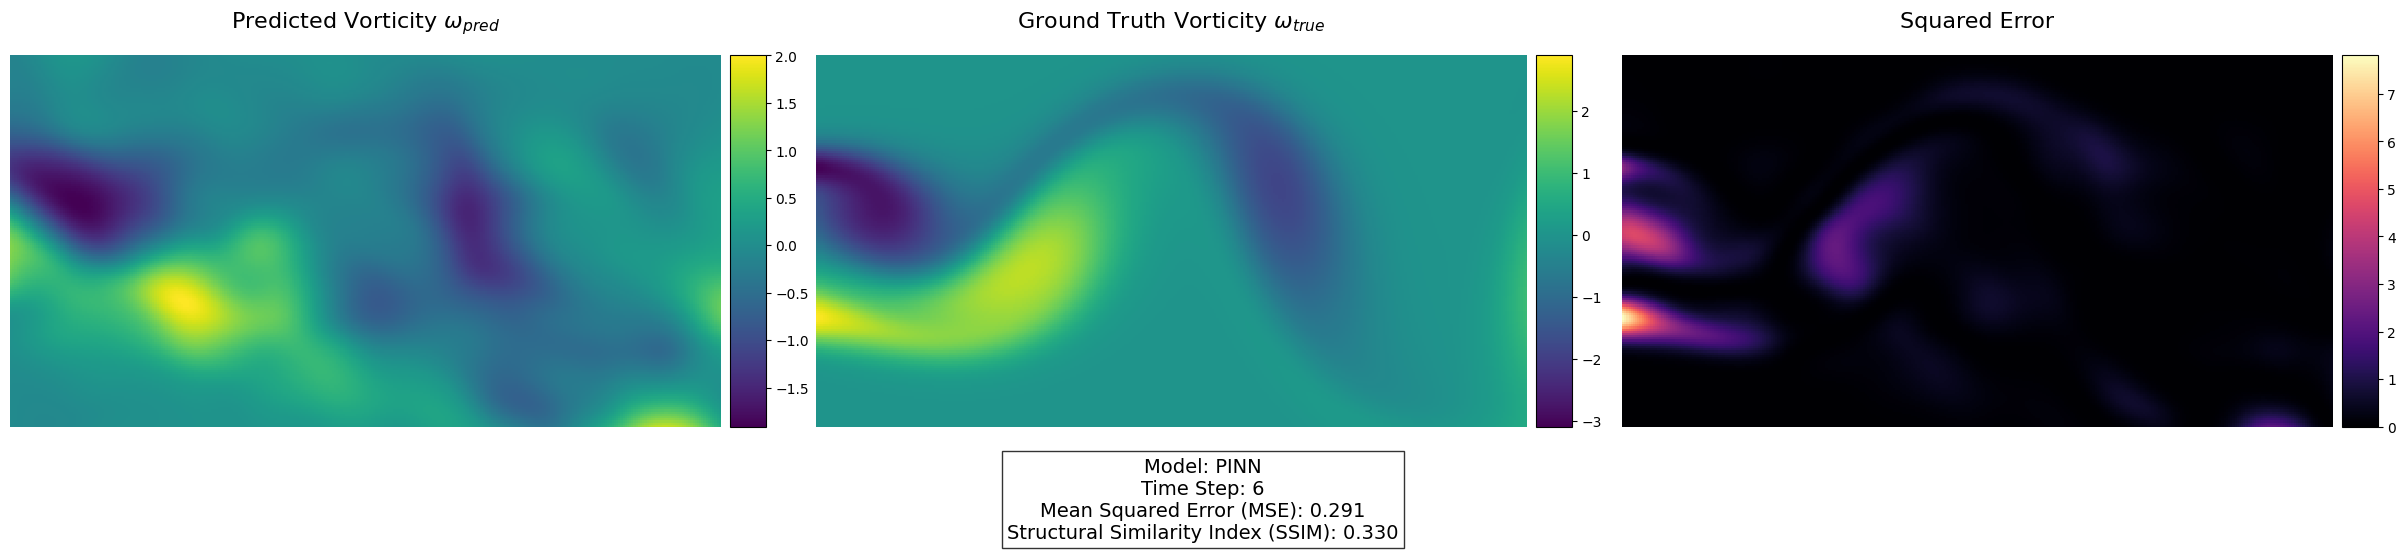

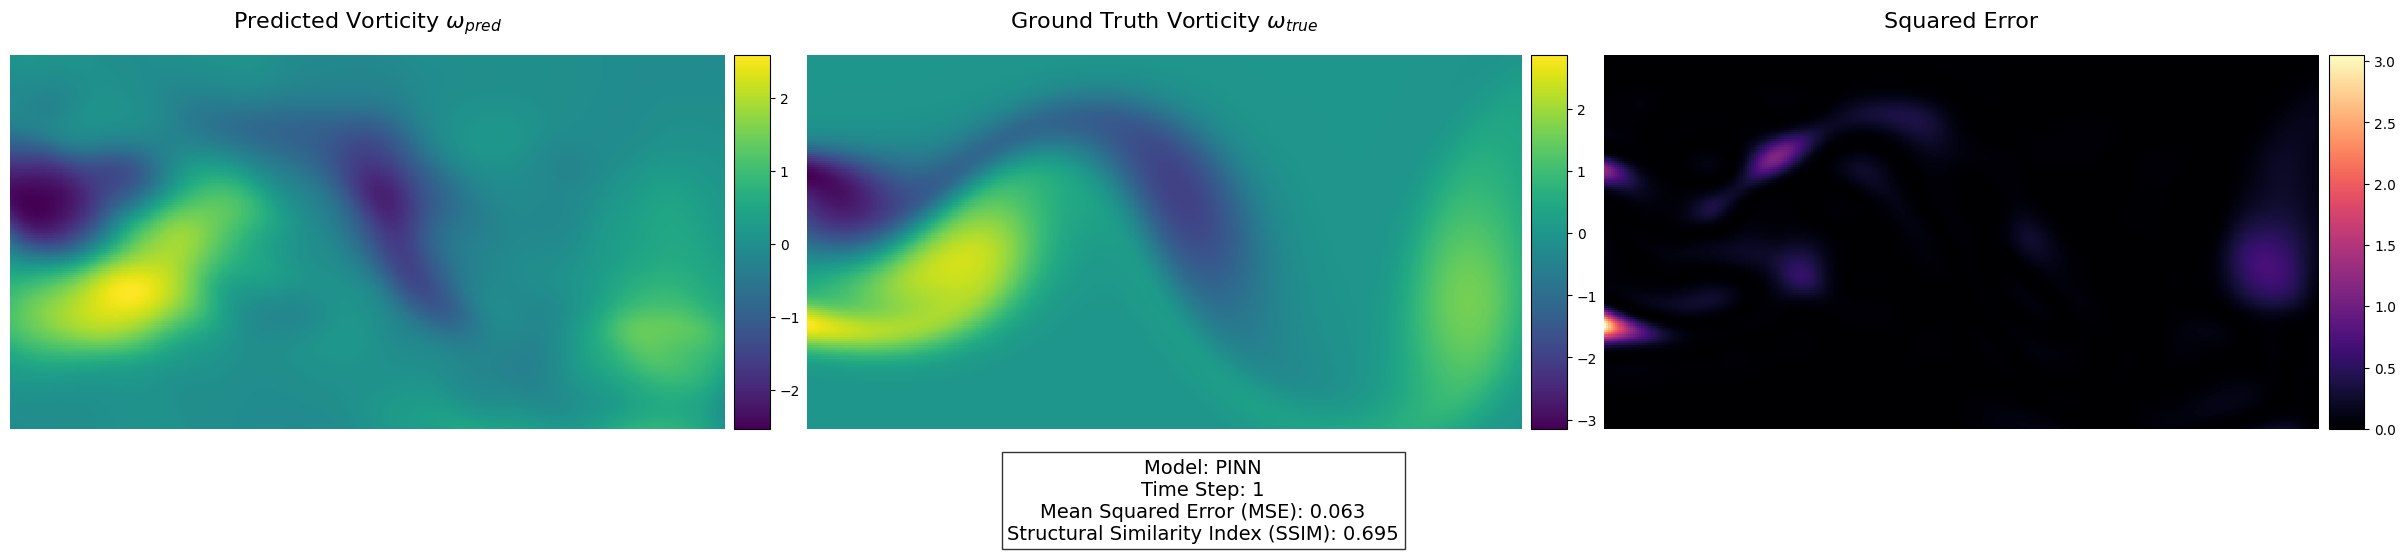

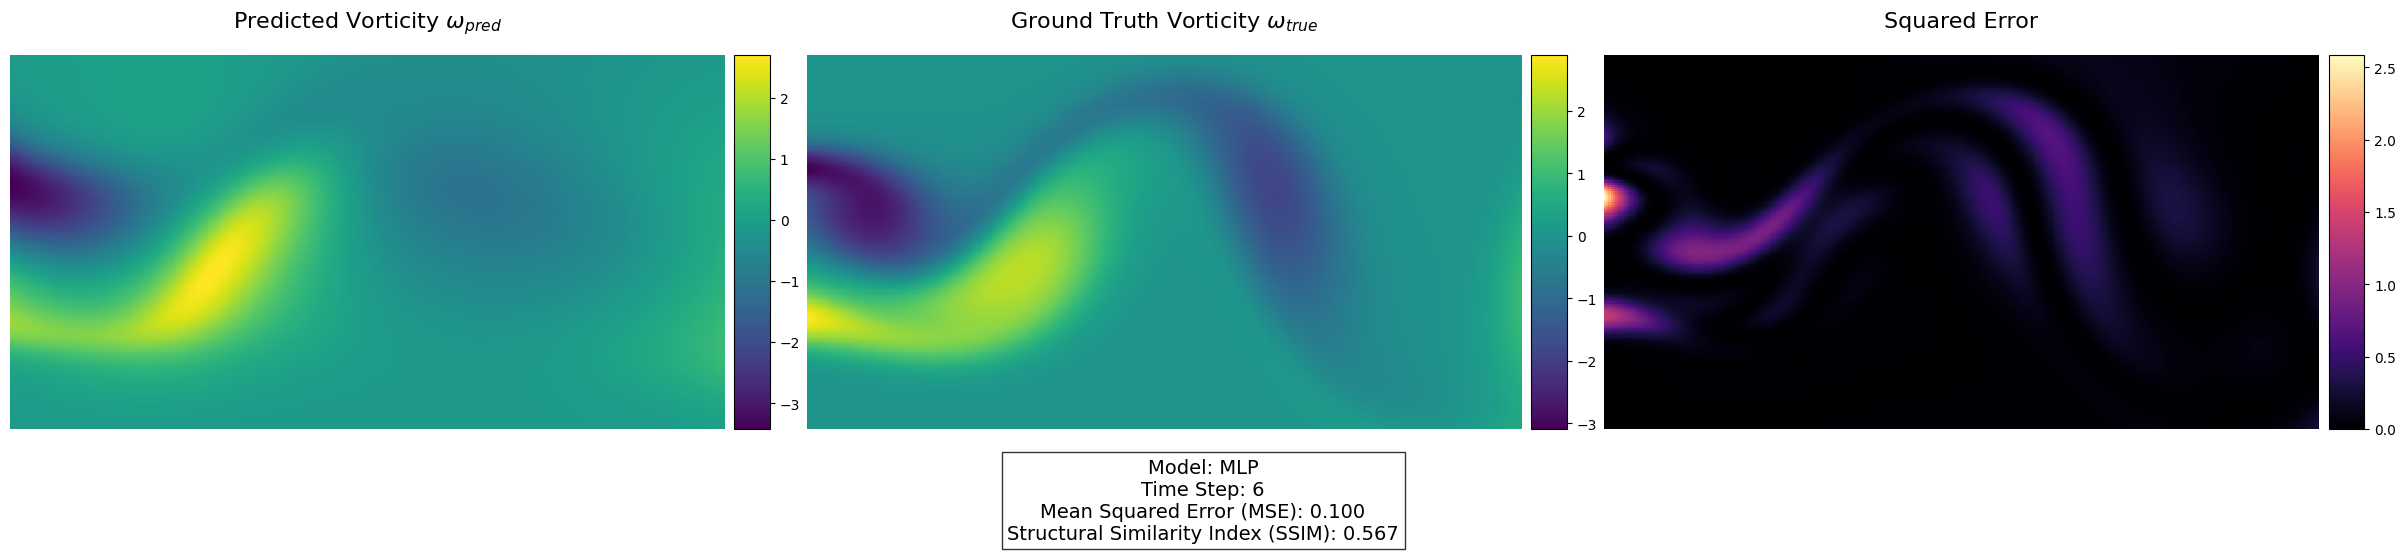

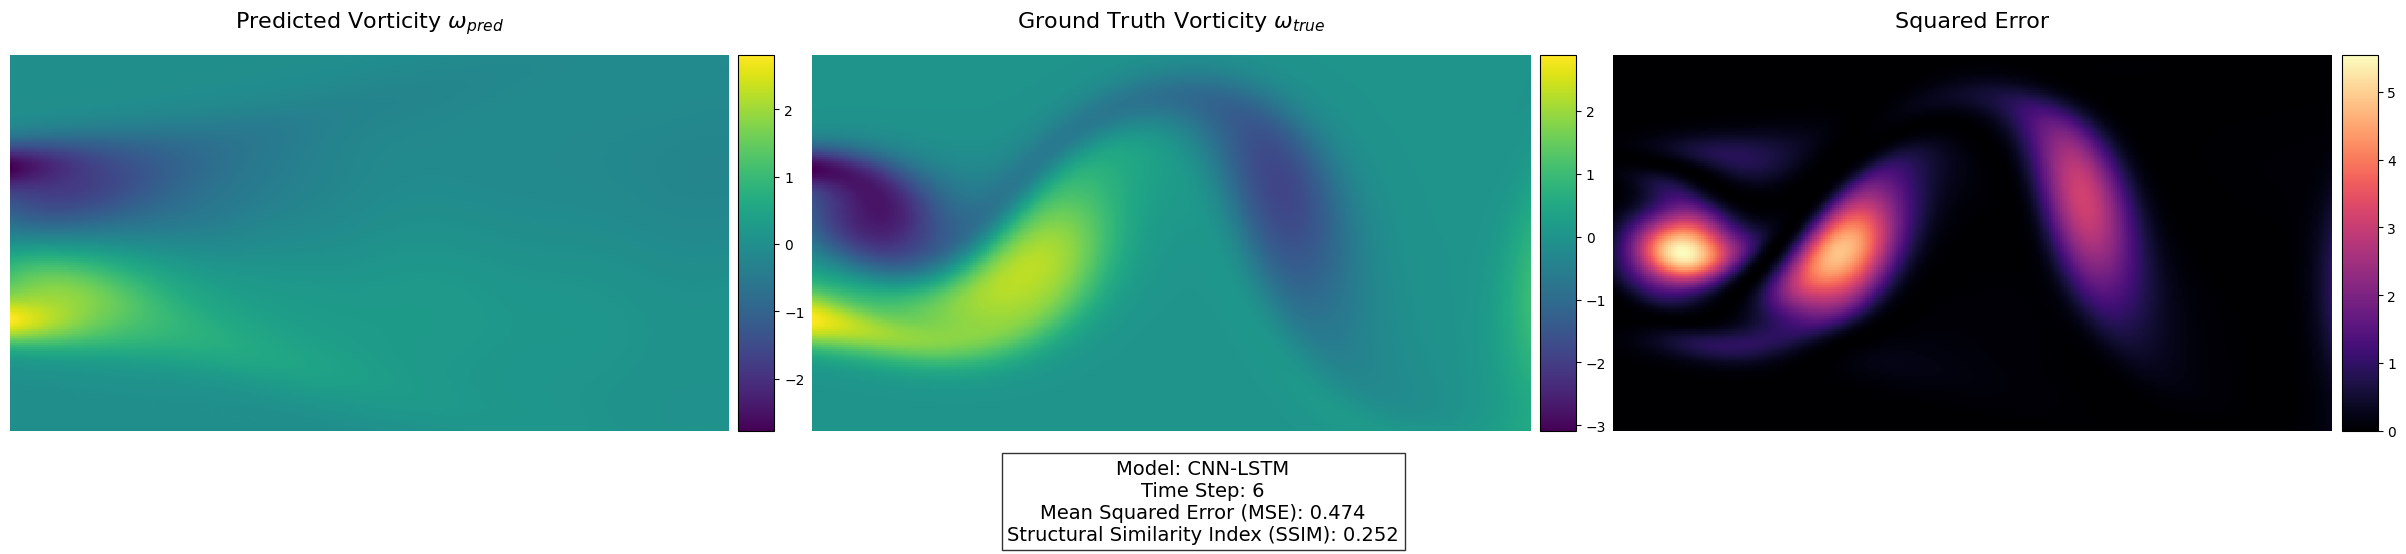

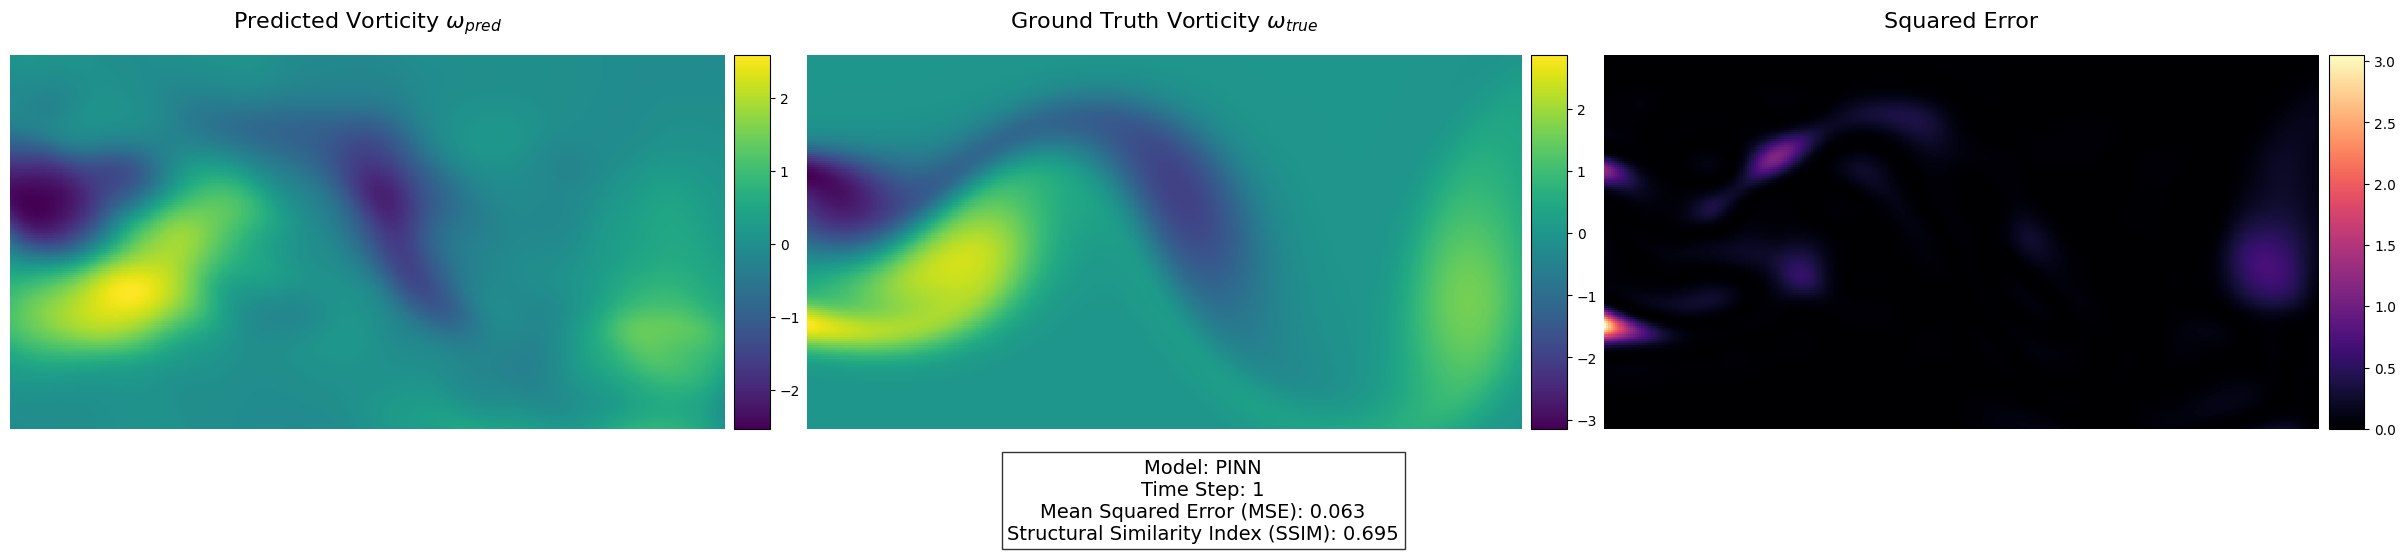

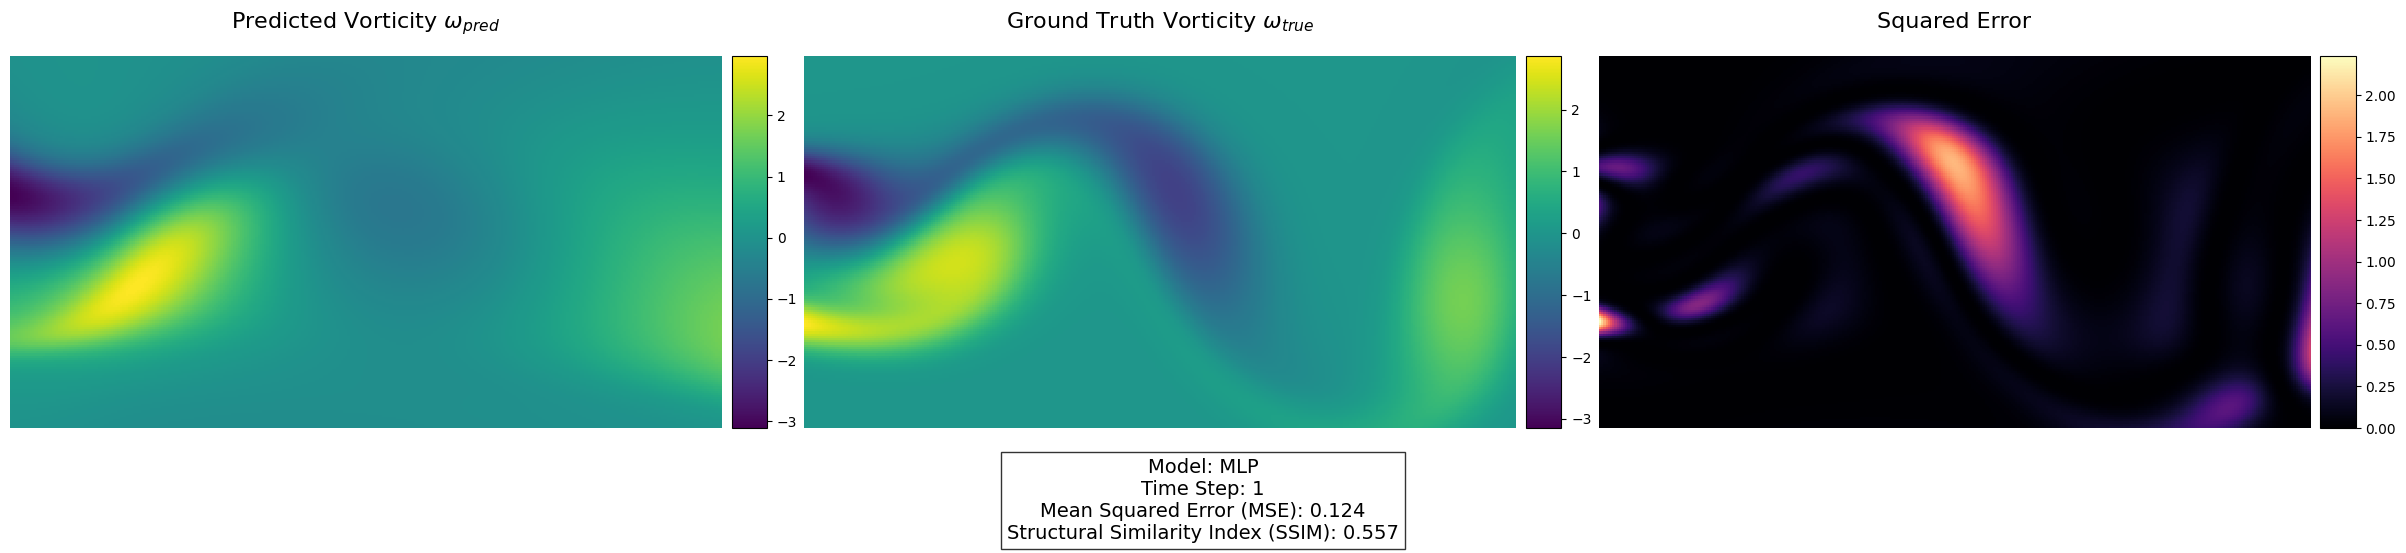

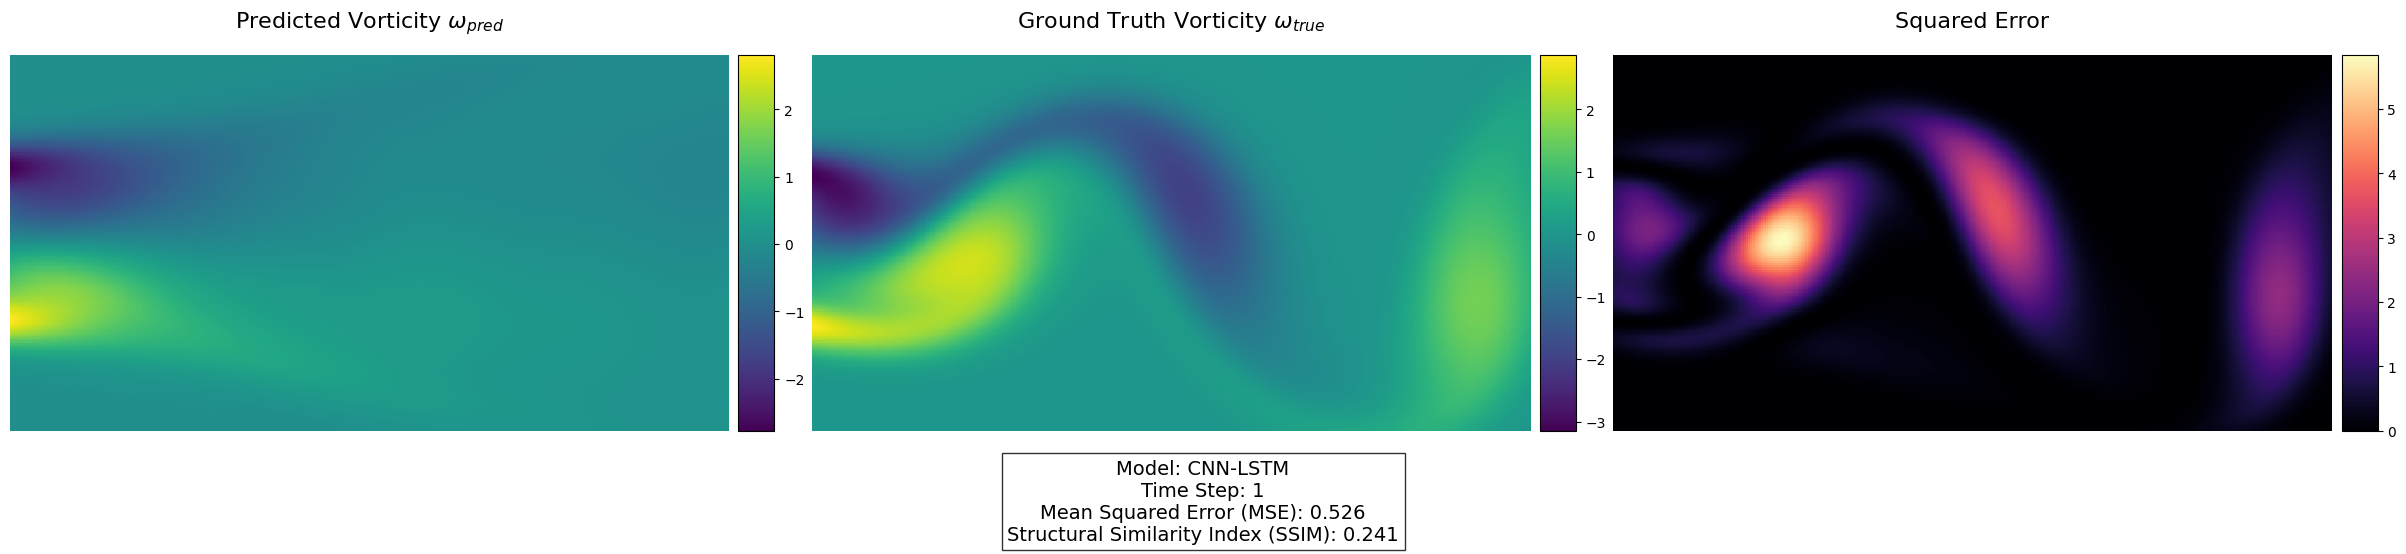

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from mpl_toolkits.axes_grid1 import make_axes_locatable
import torch

def plot_architectures(model_path, model_type, time_step=50, val_loader=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    X_star, _, _, _, _, _, _, _, _, _, W, U, V, steps, n, m = load_and_reshape_data('/content/drive/MyDrive/A3/nse.mat')

    fig, axs = plt.subplots(1, 3, figsize=(24, 8))
    fig.subplots_adjust(wspace=0.3)

    if model_type in ["PINN", "MLP"]:
        layers = [3, 32, 32, 32, 32, 32, 3]
        model = globals()[model_type](layers, device, 50, 1) if model_type == "PINN" else globals()[model_type](layers, device)
        model.load_state_dict(torch.load(model_path))
        model.eval()

        with torch.no_grad():
            output = model(torch.tensor(X_star, dtype=torch.float32).to(device))
        w_pred = output[:, 2].cpu().numpy().reshape(325, 170, 151)
        pred_slice = w_pred[:, :, time_step]
        true_slice = W[:, :, time_step]

    elif model_type == "CNN-LSTM":
        if val_loader is None:
            raise ValueError("val_loader is required for CNN-LSTM model")

        model = CNNLSTM(128, 8).to(device)
        model.load_state_dict(torch.load(model_path))
        model.eval()

        test_input, test_target = next(iter(val_loader))
        test_input = test_input.permute(0, 3, 4, 1, 2).to(device)

        with torch.no_grad():
            output = model(test_input).to(device)

        output = output.cpu().numpy()
        #print (output.shape)
        w_pred = output[:, 2, :, :].reshape(-1, 325, 170)
        #print (w_pred.shape)
        pred_slice = w_pred[time_step]
        true_slice = W[:, :, time_step]

    mse = np.mean((pred_slice - true_slice) ** 2)
    ssim_index = ssim(true_slice, pred_slice, data_range=pred_slice.max() - pred_slice.min())
    error = (pred_slice - true_slice) ** 2

    pred_slice = np.rot90(pred_slice)
    true_slice = np.rot90(true_slice)
    error = np.rot90(error)

    titles = ['Predicted Vorticity $\omega_{pred}$',
              'Ground Truth Vorticity $\omega_{true}$',
              'Squared Error']
    images = [pred_slice, true_slice, error]
    cmaps = ['viridis', 'viridis', 'magma']

    for ax, title, img, cmap in zip(axs, titles, images, cmaps):
        im = ax.imshow(img, cmap=cmap, aspect='equal', interpolation='nearest')
        ax.set_title(title, fontsize=16, pad=20)
        ax.set_xlabel('Y', fontsize=12)
        ax.set_ylabel('X', fontsize=12)
        ax.tick_params(axis='both', which='major', labelsize=10)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(im, cax=cax)
        cbar.ax.tick_params(labelsize=10)
        ax.axis('off')

    plt.tight_layout(pad=0.5)
    fig.text(0.5, 0.23,
             f'Model: {model_type}\n'
             f'Time Step: {time_step}\n'
             f'Mean Squared Error (MSE): {mse:.3f}\n'
             f'Structural Similarity Index (SSIM): {ssim_index:.3f}',
             ha='center', va='top', fontsize=14, bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

    plt.show()

# # Example usage:
plot_architectures('/content/model_PINN.pth', model_type="PINN", time_step=6)
plot_architectures('/content/model_PINN.pth', model_type="PINN", time_step=1)

plot_architectures('/content/baseline_MLP.pth', model_type="MLP", time_step=6)
plot_architectures('/content/baseline_CNNLSTM.pth', model_type="CNN-LSTM", time_step=6, val_loader=val_loader)

plot_architectures('/content/model_PINN.pth', model_type="PINN", time_step=1)
plot_architectures('/content/baseline_MLP.pth', model_type="MLP", time_step=1)
plot_architectures('/content/baseline_CNNLSTM.pth', model_type="CNN-LSTM", time_step=1, val_loader=val_loader)